### Packages

In [1]:
# cd /project/3022057.01/IFA
# module load anaconda3
# source activate IFAenv
# jupyter notebook --no-browser --ip=* --port=8888 --NotebookApp.token=''

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import sawtooth
from scipy.linalg import svdvals
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.covariance import LedoitWolf
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso, Lasso, LassoCV, ElasticNet, MultiTaskLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from nilearn import plotting as nplot
from nilearn import image as nimg
from nilearn import datasets, plotting
from nilearn.regions import connected_label_regions
from nilearn import input_data
from nilearn import image as nimg
from nilearn.connectome import ConnectivityMeasure
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann, unupper
from pyriemann.utils.distance import distance_riemann
from pyriemann.utils.base import logm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# import torch

### Load Atlas & Create Mask

Number of Labels in Mask:  208


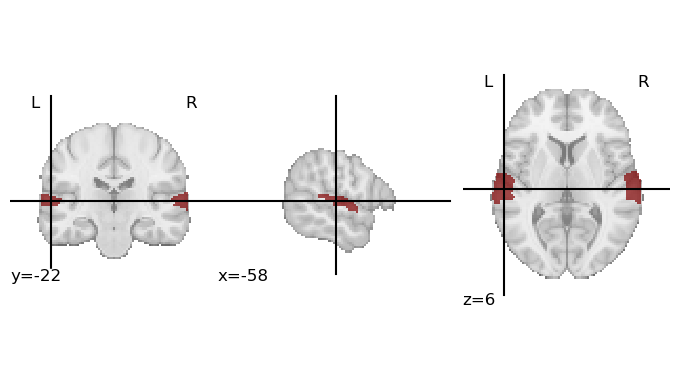

In [3]:
# Parcellation and Atlas References:
    # https://dartbrains.org/content/Parcellations.html#summary-of-differences-between-parcellations
    # https://nipy.org/nibabel/nibabel_images.html
    # https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
    # https://nilearn.github.io/dev/modules/generated/nilearn.regions.Parcellations.html
    # https://dartbrains.org/content/Parcellations.html#nilearn
    # https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html

def create_mask(dir='../resources/rois/', n_rois=200, yeo_networks=17, resolution_mm=1):
    """
    Create a brain mask using the Schaefer atlas or a provided directory.
    
    Parameters:
    dir (str): Directory to fetch or load atlas data from.
    n_rois (int): Number of regions of interest.
    yeo_networks (int): Number of Yeo networks.
    resolution_mm (int): Resolution in millimeters.

    Returns:
    tuple: NiftiLabelsMasker object, atlas image, and region labels.
    """
    if dir == '../resources/rois/':
        parcel_dir = dir
        schaefer = datasets.fetch_atlas_schaefer_2018(n_rois, yeo_networks, resolution_mm, data_dir=parcel_dir)
        atlas_schaefer = schaefer['maps']
        atlas = connected_label_regions(atlas_schaefer)
    else:
        atlas = dir

    masker = input_data.NiftiLabelsMasker(labels_img=atlas, standardize=True)
    atlas_img = nimg.load_img(atlas)
    region_labels = np.unique(atlas_img.get_fdata())
    region_labels = np.setdiff1d(region_labels, [0])  # Remove the background label (0)

    return masker, atlas, region_labels

def view_labels(atlas, roi='a == 1'):
    """
    View the labels of the atlas for a specified region of interest (ROI).
    
    Parameters:
    atlas (Nifti1Image): Atlas image.
    roi (str): Mathematical expression to specify the ROI.

    """
    roi_mask = nimg.math_img(roi, a=atlas)
    nplot.plot_roi(roi_mask, cmap='jet')

fine_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
# course_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_coarse_79parcels.nii.gz"  # Uncomment this, comment above, and change below for course ICP
mask, atlas, region_labels = create_mask(fine_ICP)
print("Number of Labels in Mask: ", len(region_labels))
view_labels(atlas)

### DONT RUN (Unless Subjects Are Not Parcellated) Load and Parcellate Subjects (REVIST INCOMPLETE)

In [4]:
def load(n=0, folder1=0):
    """
    Load data for a specified number of subjects and fMRI tasks, only if they have not been parcellated.
    """
    if n < 0:
        n = 0
    elif n > 1113:
        n = 1113

    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    folders = [
        "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
        "tfMRI_EMOTION_LR", "tfMRI_EMOTION_RL", "tfMRI_GAMBLING_LR", "tfMRI_GAMBLING_RL",
        "tfMRI_LANGUAGE_LR", "tfMRI_LANGUAGE_RL", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL",
        "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL",
        "tfMRI_WM_LR", "tfMRI_WM_RL"
    ]

    if folder1 + 1 >= len(folders):
        raise IndexError(f"Invalid folder1 index: {folder1}. Check folder list.")

    selected_subjects = []
    subjects = [sub for sub in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, sub))]

    for subject in subjects:
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + ".nii.gz")
        subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 1], folders[folder1 + 1] + ".nii.gz")

        if os.path.exists(subject_data1) and os.path.exists(subject_data2):
            selected_subjects.append((subject_data1, subject_data2))
    
    return selected_subjects

def parcellate_glass(sub_data, masker, region_labels, verbose=False):
    """
    Parcellate fMRI data into regions of interest.
    """
    parcellated = masker.fit_transform(sub_data)
    num_labels = len(region_labels)
    
    num_timepoints = sub_data.shape[3]
    final_signal = np.zeros((num_timepoints, num_labels))

    regions_kept = np.array(masker.labels_, dtype='int')
    label_to_index = {label: i for i, label in enumerate(region_labels)}

    for i, label in enumerate(regions_kept):
        if label in label_to_index:
            final_signal[:, label_to_index[label]] = parcellated[:, i]
        else:
            if verbose:
                print(f"Label {label} not found in region_labels.")

    if verbose:
        print("Number of atlas labels: ", num_labels)
        print("Number of parcellated labels: ", len(masker.labels_))
        print("Missing labels: ", set(region_labels) - set(np.unique(masker.labels_)))
    return final_signal

def parcellate_all(allsubs, mask, region_labels, save=False, verbose=False, location=''):
    """
    Parcellate data for all subjects and tasks, and optionally save the results.
    """
    main_output_directory = os.path.normpath(r"/project/3022057.01/")

    alldata = []
    for sub in allsubs:
        concatenated_parcellated_data = []
        for task in sub:
            if verbose:
                print(task)
            sub_data = nimg.load_img(task)
            parcellated = parcellate_glass(sub_data, mask, region_labels, verbose=verbose)
            concatenated_parcellated_data.append(parcellated)
        
        concatenated_parcellated_data = np.concatenate(concatenated_parcellated_data, axis=0)
        if verbose:
            print(concatenated_parcellated_data.shape)
        alldata.append(concatenated_parcellated_data)

        if save:
            try:
                subdir = sub[0][sub[0].find("S1200") + len("S1200"):].split("/")[1]
                taskdir = sub[0][sub[0].find("Results") + len("Results"):].split("/")[1]
                sub_output_directory = os.path.join(main_output_directory, location, subdir)
                os.makedirs(sub_output_directory, exist_ok=True)
                output_filename = os.path.join(sub_output_directory, f"{taskdir}_LR_RL_parcellated.npy")
                if verbose:
                    print(output_filename)
                np.save(output_filename, concatenated_parcellated_data)
            except Exception as e:
                print(f"Error saving data for {task}: {e}")
    return alldata

n = 1000
folder1 = 8  # For example, tfMRI_LANGUAGE_LR

allsubs = load(n, folder1)
print(allsubs)
alldata = parcellate_all(allsubs, mask, region_labels, save=True, verbose=False, location="ICP_parcellated_subs_alt")

[('/project_cephfs/3022017.01/S1200/210112/MNINonLinear/Results/tfMRI_LANGUAGE_LR/tfMRI_LANGUAGE_LR.nii.gz', '/project_cephfs/3022017.01/S1200/210112/MNINonLinear/Results/tfMRI_LANGUAGE_RL/tfMRI_LANGUAGE_RL.nii.gz'), ('/project_cephfs/3022017.01/S1200/579665/MNINonLinear/Results/tfMRI_LANGUAGE_LR/tfMRI_LANGUAGE_LR.nii.gz', '/project_cephfs/3022017.01/S1200/579665/MNINonLinear/Results/tfMRI_LANGUAGE_RL/tfMRI_LANGUAGE_RL.nii.gz'), ('/project_cephfs/3022017.01/S1200/922854/MNINonLinear/Results/tfMRI_LANGUAGE_LR/tfMRI_LANGUAGE_LR.nii.gz', '/project_cephfs/3022017.01/S1200/922854/MNINonLinear/Results/tfMRI_LANGUAGE_RL/tfMRI_LANGUAGE_RL.nii.gz'), ('/project_cephfs/3022017.01/S1200/517239/MNINonLinear/Results/tfMRI_LANGUAGE_LR/tfMRI_LANGUAGE_LR.nii.gz', '/project_cephfs/3022017.01/S1200/517239/MNINonLinear/Results/tfMRI_LANGUAGE_RL/tfMRI_LANGUAGE_RL.nii.gz'), ('/project_cephfs/3022017.01/S1200/329440/MNINonLinear/Results/tfMRI_LANGUAGE_LR/tfMRI_LANGUAGE_LR.nii.gz', '/project_cephfs/3022017.01

: 